In [1]:
from sklearn import datasets
import pandas as pd
from tg.common.ml import batched_training as bt

## Binary classification

In [2]:
from yo_fluq_ds import *

def get_binary_classification_bundle():
    ds = datasets.load_breast_cancer()
    features = pd.DataFrame(ds['data'], columns=ds['feature_names'])
    df = pd.DataFrame(ds['target'], columns=['label'])
    df['split'] = bt.train_display_test_split(df, 0.2, 0.2, 'label')
    bundle = bt.DataBundle(index=df, features=features)
    return bundle

get_binary_classification_bundle().index.head()

,label,split
0,0,train
1,0,train
2,0,display
3,0,test
4,0,train


In [3]:
get_binary_classification_bundle().features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory, Conventions
from tg.common.ml import dft

def get_feature_extractor():
    feature_extractor = (bt.PlainExtractor
                 .build('features')
                 .index('features')
                 .apply(transformer = dft.DataFrameTransformerFactory.default_factory())
                )
    return feature_extractor
    
def get_binary_label_extractor():
    label_extractor = (bt.PlainExtractor
                   .build(Conventions.LabelFrame)
                   .index()
                   .apply(take_columns=['label'], transformer=None)
                  )
    return label_extractor

def test_extractor(extractor, bundle):
    extractor.fit(bundle)
    return extractor.extract(bundle)

db = get_binary_classification_bundle()
idb = bt.IndexedDataBundle(db.index, db)
test_extractor( get_feature_extractor(), idb).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [5]:
test_extractor(get_binary_label_extractor(), idb).head()

,label
0,0
1,0
2,0
3,0
4,0


In [6]:
import torch

class ClassificationNetwork(torch.nn.Module):
    def __init__(self, hidden_size, sample):
        super(ClassificationNetwork, self).__init__()
        self.hidden = torch.nn.Linear(sample['features'].shape[1], hidden_size)
        self.output = torch.nn.Linear(hidden_size, sample['label'].shape[1])

    def forward(self, input):
        X = input['features']
        X = torch.tensor(X.astype(float).values).float()
        X = self.hidden(X)
        X = torch.sigmoid(X)
        X = self.output(X)
        X = torch.sigmoid(X)
        return X


<AxesSubplot:xlabel='iteration'>

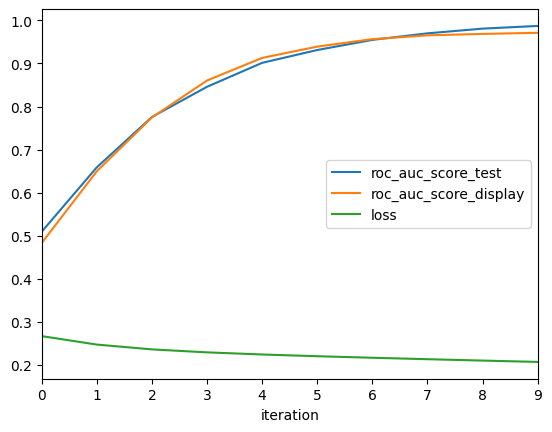

In [7]:
from sklearn.metrics import roc_auc_score
from tg.common import Logger
Logger.disable()

class ClassificationTask(TaskFactory):
    def create_task(self, data, env):
        metrics = bt.MetricPool().add_sklearn(roc_auc_score)
        self.instantiate_default_task(epoch_count=10, batch_size=1000, mini_batch_size=None, metric_pool=metrics)
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        self.setup_model(lambda _, sample: ClassificationNetwork(100, sample))
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

<AxesSubplot:xlabel='iteration'>

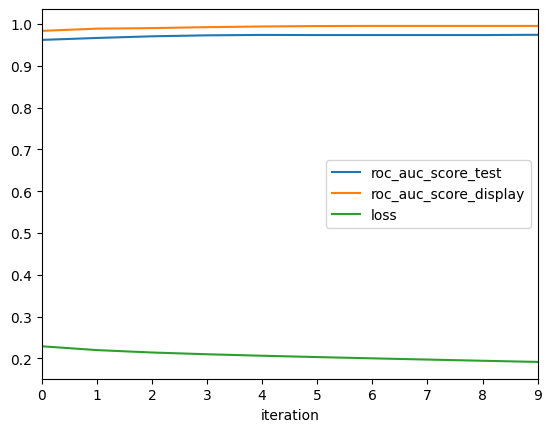

In [8]:
from tg.common.ml.batched_training.torch import networks as btn

class ClassificationTask(TaskFactory):
    def create_task(self, data, env):
        metrics = bt.MetricPool().add_sklearn(roc_auc_score)
        self.instantiate_default_task(epoch_count=10, batch_size=1000, mini_batch_size=None, metric_pool=metrics)
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        network_factory = btn.FullyConnectedNetwork.Factory([100],output='label').prepend_extraction('features')
        self.setup_model(network_factory)
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

## Multilabel classification

In [9]:
def get_multilabel_classification_bundle():
    ds = datasets.load_iris()
    features = pd.DataFrame(ds['data'], columns=ds['feature_names'])
    df = pd.DataFrame(ds['target_names'][ds['target']], columns = ['label'])
    df['split'] = bt.train_display_test_split(df, 0.2, 0.2, 'label')
    bundle = bt.DataBundle(index=df, features=features)
    return bundle
    
get_multilabel_classification_bundle().index.head()

,label,split
0,setosa,display
1,setosa,test
2,setosa,train
3,setosa,train
4,setosa,train


In [10]:
def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                   .build(Conventions.LabelFrame)
                   .index()
                   .apply(take_columns=['label'], transformer=dft.DataFrameTransformerFactory.default_factory())
                  )
    return label_extractor

db = get_multilabel_classification_bundle()
idb = bt.IndexedDataBundle(db.index, db)
test_extractor( get_multilabel_extractor(), idb).head()

,label_virginica,label_versicolor,label_setosa
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


<AxesSubplot:xlabel='iteration'>

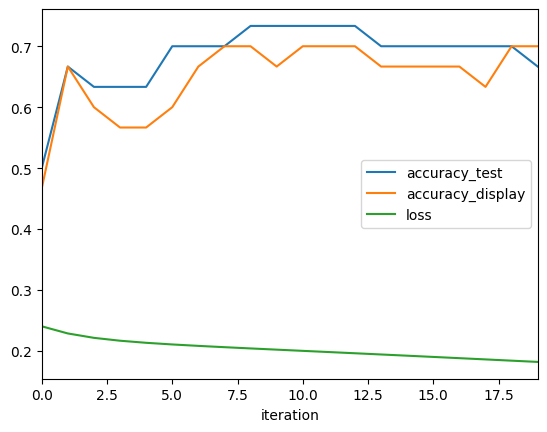

In [11]:
class MulticlassMetrics(bt.Metric):
    def __init__(self, add_accuracy = True, add_rating = False):
        self.add_accuracy = add_accuracy
        self.add_rating = add_rating
    
    def get_names(self):
        result = []
        if self.add_accuracy:
            result.append('accuracy')
        if self.add_rating:
            result.append('rating')
        return result
    
    def measure(self, df, _):
        prefix = 'true_label_'
        labels = []
        for c in df.columns:
            if c.startswith(prefix):
                labels.append(c.replace(prefix,''))

        def ustack(df, prefix, cols, name):
            df = df[[prefix+c for c in cols]]
            df.columns=[c for c in cols]
            df = df.unstack().to_frame(name)
            return df

        predicted = ustack(df, 'predicted_label_', labels, 'predicted')
        true = ustack(df, 'true_label_', labels, 'true')
        df = predicted.merge(true, left_index=True, right_index=True).reset_index()
        df.columns=['label','sample','predicted','true']
        df = df.feed(fluq.add_ordering_column('sample',('predicted',False), 'predicted_rating'))

        match = (df.loc[df.predicted_rating==0].set_index('sample').true>0.5)
        rating = df.loc[df.true>0.5].set_index('sample').predicted_rating
        result = []
        if self.add_accuracy:
            result.append(match.mean())
        if self.add_rating:
            result.append(rating.mean())
        return result


class ClassificationTask(TaskFactory):
    def create_task(self, data, env):
        metrics = bt.MetricPool().add(MulticlassMetrics())
        self.instantiate_default_task(epoch_count=20, batch_size=10000, mini_batch_size=None, metric_pool=metrics)
        self.setup_batcher(data, [get_feature_extractor(), get_multilabel_extractor()])
        self.setup_model(lambda _, sample: ClassificationNetwork(20, sample), learning_rate=1)
        
task = ClassificationTask()
result = task.run(get_multilabel_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()